# 설치/준비

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
# 1. 폰트 설치
!apt-get -qq install fonts-nanum

# 2. matplotlib 설정
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# 3. 나눔고딕 폰트 경로와 객체 생성
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

# 경고 메시지 끄기
import warnings
warnings.filterwarnings('ignore')

# matplotlib 폰트 관련 경고 제거
import logging
logging.getLogger('matplotlib.font_manager').disabled = True


Selecting previously unselected package fonts-nanum.
(Reading database ... 126102 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [ ]:
# Google Drive 마운트 (Colab에서 실행하는 경우 필요)
from google.colab import drive
drive.mount('/content/drive')

# 경로 지정
base_path = '/content/drive/MyDrive/교육정책데이터분석'

# 파일 경로
df_path = base_path + '/서울특별시_국공립_초중고_환경위생관리현황.csv'
sdf_path = base_path + '/서울시_통합학교정보_최종본.csv'

# CSV 파일 로드
df = pd.read_csv(df_path)
sdf =  pd.read_csv(sdf_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 환경변수 시각화
- 폼알데하이드 : 100이하
- 벤젠 : 30 이하
- 톨루엔 : 1000 이하
- 에틸벤젠 : 360 이하
- 자일렌 : 700 이하
- 스티렌 : 300 이하
- TVOC : 400 이하


이상치 있는 학교 파악 - 이상치 없음

In [ ]:
# '서울특별시 ㅇㅇ구' → 'ㅇㅇ구' 추출
df["ADRCD_NM"] = df["ADRCD_NM"].str.extract(r"서울특별시\s+(.+구)")


### 초과치

In [ ]:
targets = {
    "폼알데하이드": {
        "first": "HCHO_RSLT_NMVL",
        "first": "HCHO_RSLT_NMVL_2",
        "final": "HCHO_RSLT_NMVL_3",
        "limit": 100,
        "risk_score": 40
    },
    "벤젠": {
        "first": "BENZENE_RSLT_NMVL",
        "middle": "BENZENE_RSLT_NMVL_2",
        "final": "BENZENE_RSLT_NMVL_3",
        "limit": 30,
        "risk_score": 40
    },
    "톨루엔": {
        "first": "TOLUENE_RSLT_NMVL",
        "middle": "TOLUENE_RSLT_NMVL_2",
        "final": "TOLUENE_RSLT_NMVL_3",
        "limit": 1000,
        "risk_score": 20
    },
    "에틸벤젠": {
        "first": "ETHY_BENZENE_RSLT_NMVL",
        "middle": "ETHY_BENZENE_RSLT_NMVL_2",
        "final": "ETHY_BENZENE_RSLT_NMVL_3",
        "limit": 360,
        "risk_score": 25
    },
    "자일렌": {
        "first": "XYLENE_RSLT_NMVL",
        "middle": "XYLENE_RSLT_NMVL_2",
        "final": "XYLENE_RSLT_NMVL_3",
        "limit": 700,
        "risk_score": 20
    },
    "스티렌": {
        "first": "STYLENE_RSLT_NMVL",
        "middle": "STYLENE_RSLT_NMVL_2",
        "final": "STYLENE_RSLT_NMVL_3",
        "limit": 300,
        "risk_score": 25
    },
    "TVOC" : {
    "first": "VOCS_RSLT_NMVL",
    "middle": "VOCS_RSLT_NMVL_2",
    "final": "VOCS_RSLT_NMVL_3",
    "limit": 400,
    "risk_score": 30,
}
}


In [ ]:
limit_exceed_any_count = {}      # {material: {SEM_STR: count}}
limit_exceed_last_details = {}   # {material: {SEM_STR: DataFrame}}

for material, info in targets.items():
    first_col = info.get("first")
    middle_col = info.get("middle", None)  # 없을 수도 있음
    final_col = info.get("final")
    limit = info["limit"]

    any_exceed_count = {}
    last_exceed_rows = {}

    for _, row in df.iterrows():
        sem = row.get("SEM_STR", "알수없음")  # 상하반기 정보, 없으면 "알수없음" 처리

        # 초기화
        if sem not in any_exceed_count:
            any_exceed_count[sem] = 0
        if sem not in last_exceed_rows:
            last_exceed_rows[sem] = []

        # 측정값 불러오기
        first = pd.to_numeric(row.get(first_col), errors='coerce')
        middle = pd.to_numeric(row.get(middle_col), errors='coerce') if middle_col else np.nan
        final = pd.to_numeric(row.get(final_col), errors='coerce')

        # 1단계: 어느 하나라도 초과되면 카운트
        if any([(not pd.isna(v) and v >= limit) for v in [first, middle, final]]):
            any_exceed_count[sem] += 1

        # 2단계: 마지막으로 기록된 값이 초과되면 저장
        for val in [final, middle, first]:  # 순서대로 마지막 관측값 찾기
            if not pd.isna(val):
                if val >= limit:
                    last_exceed_rows[sem].append({
                        "학교명": row.get("SCHUL_NM"),
                        "최종값": val,
                        "limit": limit,
                        "상하반기": sem
                    })
                break

    # 저장 (상하반기별)
    limit_exceed_any_count[material] = any_exceed_count
    limit_exceed_last_details[material] = {sem: pd.DataFrame(rows) for sem, rows in last_exceed_rows.items()}


In [ ]:
# limit_exceed_any_count 평탄화
flattened_counts = {}
for material, sem_dict in limit_exceed_any_count.items():
    for sem, count in sem_dict.items():
        key = f"{material} ({sem})"
        flattened_counts[key] = count

# 시리즈 생성 및 정렬 출력
count_series = pd.Series(flattened_counts).sort_values(ascending=False)
print(count_series)


TVOC (상반기)      27
TVOC (하반기)      18
벤젠 (상반기)        16
에틸벤젠 (상반기)      11
벤젠 (하반기)        10
스티렌 (하반기)       10
자일렌 (상반기)       10
에틸벤젠 (하반기)       9
자일렌 (하반기)        9
스티렌 (상반기)        9
톨루엔 (상반기)        8
톨루엔 (하반기)        8
폼알데하이드 (상반기)     0
폼알데하이드 (하반기)     0
폼알데하이드 (nan)     0
벤젠 (nan)         0
톨루엔 (nan)        0
에틸벤젠 (nan)       0
자일렌 (nan)        0
스티렌 (nan)        0
TVOC (nan)       0
dtype: int64


In [ ]:
flattened_counts = {}
for material, sem_dict in limit_exceed_last_details.items():
    for sem, df_ in sem_dict.items():
        count = len(df_) if df_ is not None else 0
        key = f"{material} ({sem})"
        flattened_counts[key] = count

count_series = pd.Series(flattened_counts).sort_values(ascending=False)
print(count_series)

벤젠 (상반기)        15
에틸벤젠 (상반기)      11
벤젠 (하반기)        10
자일렌 (상반기)       10
스티렌 (하반기)       10
자일렌 (하반기)        9
스티렌 (상반기)        9
에틸벤젠 (하반기)       9
TVOC (하반기)       8
톨루엔 (하반기)        7
TVOC (상반기)       6
톨루엔 (상반기)        5
폼알데하이드 (상반기)     0
폼알데하이드 (하반기)     0
폼알데하이드 (nan)     0
벤젠 (nan)         0
톨루엔 (nan)        0
에틸벤젠 (nan)       0
자일렌 (nan)        0
스티렌 (nan)        0
TVOC (nan)       0
dtype: int64


### 위 결과 확인 가능
- 폼알데하이드 : 100이하
- 벤젠 : 30 이하
- 톨루엔 : 1000 이하
- 에틸벤젠 : 360 이하
- 자일렌 : 700 이하
- 스티렌 : 300 이하
- TVOC : 400 이하

In [ ]:
df_check = limit_exceed_last_details["TVOC"]
print(df_check.shape)
print(df_check.head())

df_check2 = limit_exceed_last_details["에틸벤젠"]
print(df_check2.shape)
print(df_check2.head())


df_check3 = limit_exceed_last_details["자일렌"]
print(df_check3.shape)
print(df_check3.head())

df_check4 = limit_exceed_last_details["스티렌"]
print(df_check4.shape)
print(df_check4.head())

df_chec5k = limit_exceed_last_details["톨루엔"]
print(df_chec5k.shape)
print(df_chec5k.head())



(14, 3)
         학교명    최종값  limit
0   서울문정초등학교  400.0    400
1   서울신길초등학교  400.0    400
2  서울신상도초등학교  400.0    400
3   서울청운초등학교  400.0    400
4      방이중학교  400.0    400
(20, 3)
        학교명    최종값  limit
0  서울문정초등학교  360.0    360
1  서울방이초등학교  360.0    360
2  서울신길초등학교  360.0    360
3     구룡중학교  360.0    360
4     송파중학교  360.0    360
(19, 3)
        학교명    최종값  limit
0  서울문정초등학교  700.0    700
1  서울방이초등학교  700.0    700
2  서울신길초등학교  700.0    700
3     구룡중학교  700.0    700
4     송파중학교  700.0    700
(19, 3)
        학교명    최종값  limit
0  서울문정초등학교  300.0    300
1  서울방이초등학교  300.0    300
2  서울백산초등학교  300.0    300
3  서울신길초등학교  300.0    300
4     구룡중학교  300.0    300
(12, 3)
        학교명     최종값  limit
0  서울문정초등학교  1000.0   1000
1  서울신길초등학교  1000.0   1000
2     구룡중학교  1000.0   1000
3     대영중학교  1000.0   1000
4     대영중학교  1000.0   1000


In [ ]:
print(df_chec5k.to_string())

         학교명     최종값  limit
0   서울문정초등학교  1000.0   1000
1   서울신길초등학교  1000.0   1000
2      구룡중학교  1000.0   1000
3      대영중학교  1000.0   1000
4      대영중학교  1000.0   1000
5   서울문정초등학교  1000.0   1000
6   서울대방초등학교  1000.0   1000
7   서울동일초등학교  1000.0   1000
8   서울조원초등학교  1000.0   1000
9      구룡중학교  1000.0   1000
10     세일중학교  1000.0   1000
11   여의도고등학교  1000.0   1000


### 자치구별 편차 기준

In [ ]:
deviation_outliers = []

# 각 학교에 대해 마지막 측정값 추출
records = []
for _, row in df.iterrows():
    for material, info in targets.items():
        school = row.get("SCHUL_NM")
        gu = row.get("ADRCD_NM")
        sem = row.get("SEM_STR")  # 상반기/하반기 정보

        first = pd.to_numeric(row.get(info.get("first")), errors="coerce")
        middle = pd.to_numeric(row.get(info.get("middle")), errors="coerce") if info.get("middle") else np.nan
        final = pd.to_numeric(row.get(info.get("final")), errors="coerce")

        for val in [final, middle, first]:
            if not pd.isna(val):
                records.append({
                    "학교명": school,
                    "자치구": gu,
                    "물질": material,
                    "최종값": val,
                    "상하반기": sem
                })
                break

df_last = pd.DataFrame(records)

# 자치구별 편차 기준 이상치 탐지 (2σ 초과)
grouped_outliers = []
if not df_last.empty:
    for material in df_last["물질"].unique():
        subset = df_last[df_last["물질"] == material]
        grouped = subset.groupby(["자치구", "상하반기"])  # 자치구와 상하반기 그룹화
        for (gu_name, sem), group in grouped:
            mean = group["최종값"].mean()
            std = group["최종값"].std()
            threshold = mean + 2 * std
            outliers = group[group["최종값"] > threshold].copy()
            if not outliers.empty:
                outliers["평균"] = mean
                outliers["표준편차"] = std
                outliers["기준"] = threshold
                grouped_outliers.append(outliers)

deviation_outlier_df = pd.concat(grouped_outliers, ignore_index=True) if grouped_outliers else pd.DataFrame()

# 결과 출력
print(" [자치구별 편차 이상치 - 마지막 측정값 기준] 결과 예시:")
print(deviation_outlier_df.head(30))




 [자치구별 편차 이상치 - 마지막 측정값 기준] 결과 예시:
          학교명   자치구      물질   최종값 상하반기         평균       표준편차         기준
0    서울자곡초등학교   강남구  폼알데하이드  53.6  상반기  18.027500  13.971546  45.970592
1    서울도곡초등학교   강남구  폼알데하이드  62.7  상반기  18.027500  13.971546  45.970592
2    서울신명초등학교   강동구  폼알데하이드  80.0  상반기  18.348485  13.378998  45.106480
3    혜화여자고등학교   강북구  폼알데하이드  47.3  상반기  21.916667  10.919776  43.756219
4    서울등현초등학교   강서구  폼알데하이드  78.0  상반기  23.654762  16.114245  55.883251
5    서울신월초등학교   강서구  폼알데하이드  75.0  상반기  23.654762  16.114245  55.883251
6     마곡하늬중학교   강서구  폼알데하이드  61.5  상반기  23.654762  16.114245  55.883251
7      구암고등학교   관악구  폼알데하이드  30.1  상반기  16.623500   5.879840  28.383180
8       봉림중학교   관악구  폼알데하이드  33.5  하반기  19.175000   6.889485  32.953969
9    서울용곡초등학교   광진구  폼알데하이드  49.2  상반기  14.645000  11.941677  38.528355
10  서울동구로초등학교   구로구  폼알데하이드  43.0  상반기  18.278571  10.107473  38.493517
11   서울온수초등학교   구로구  폼알데하이드  45.0  상반기  18.278571  10.107473  38.493517
12      고척중학교   구로구  폼알데하이드  

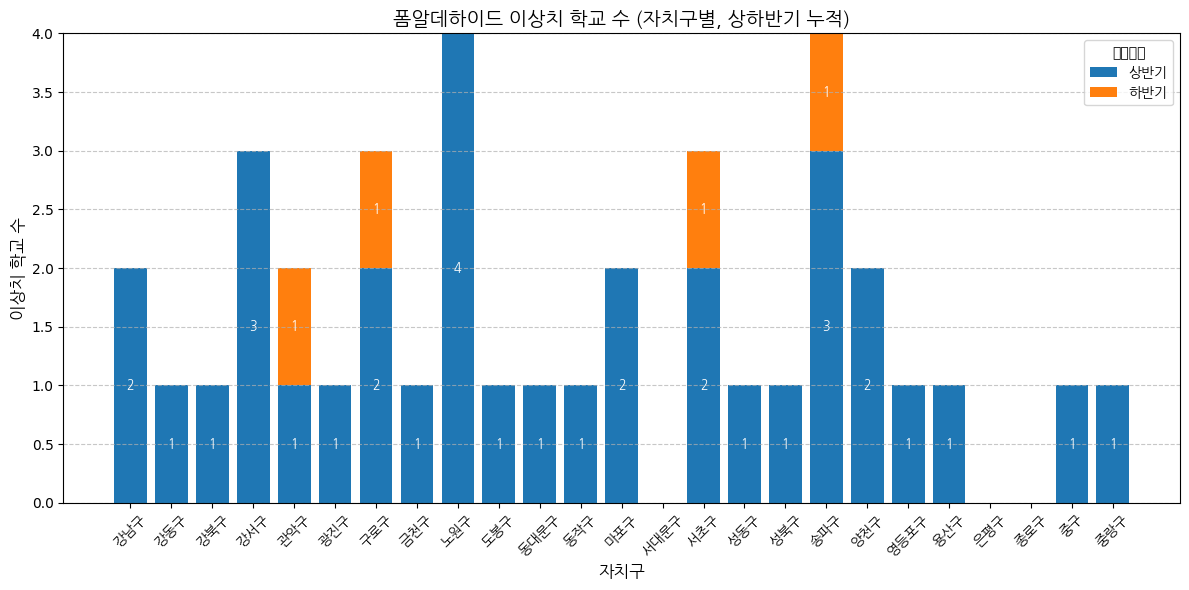

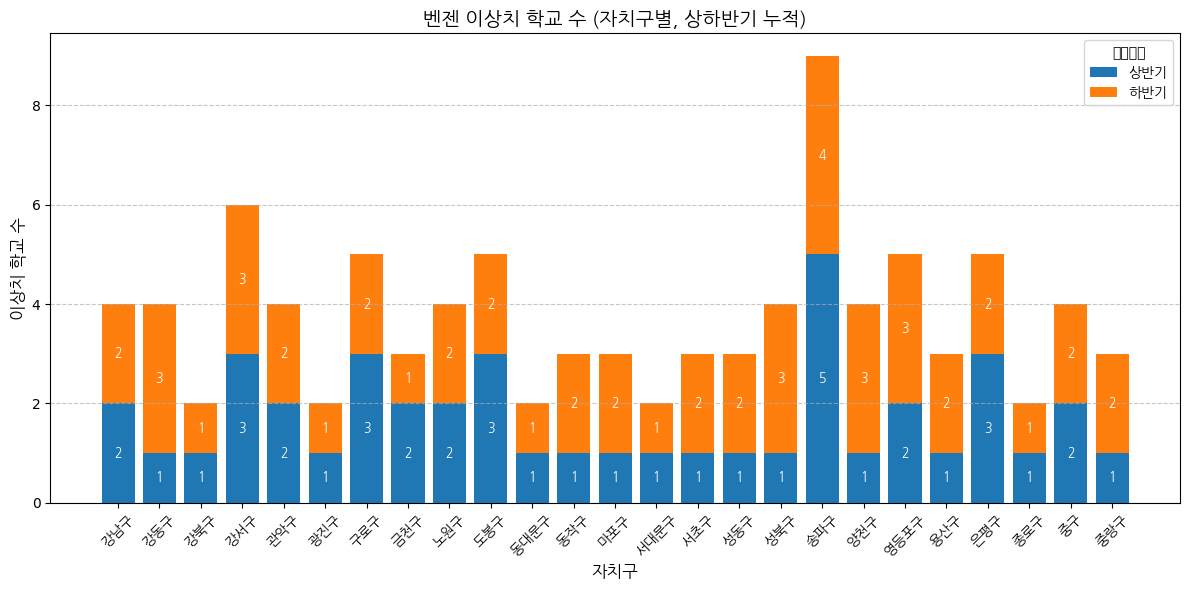

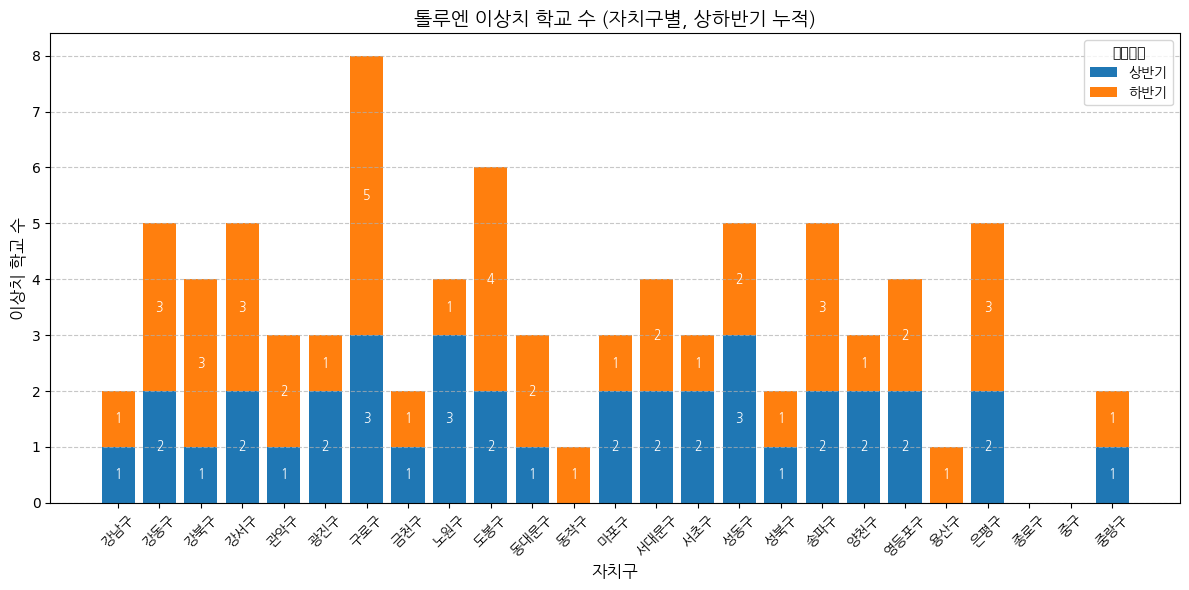

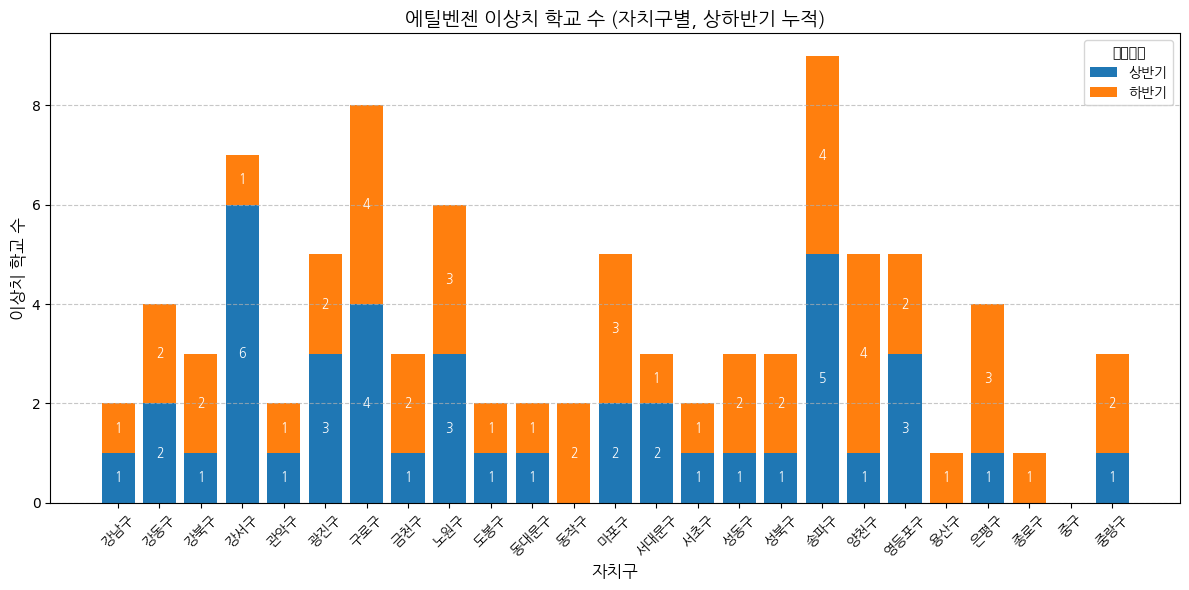

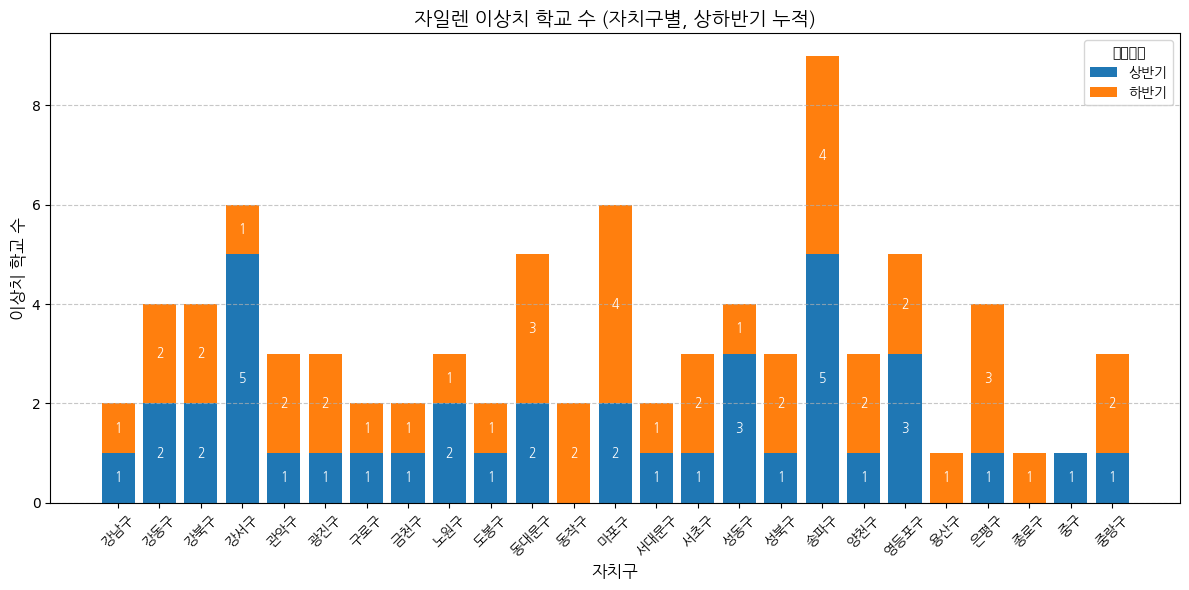

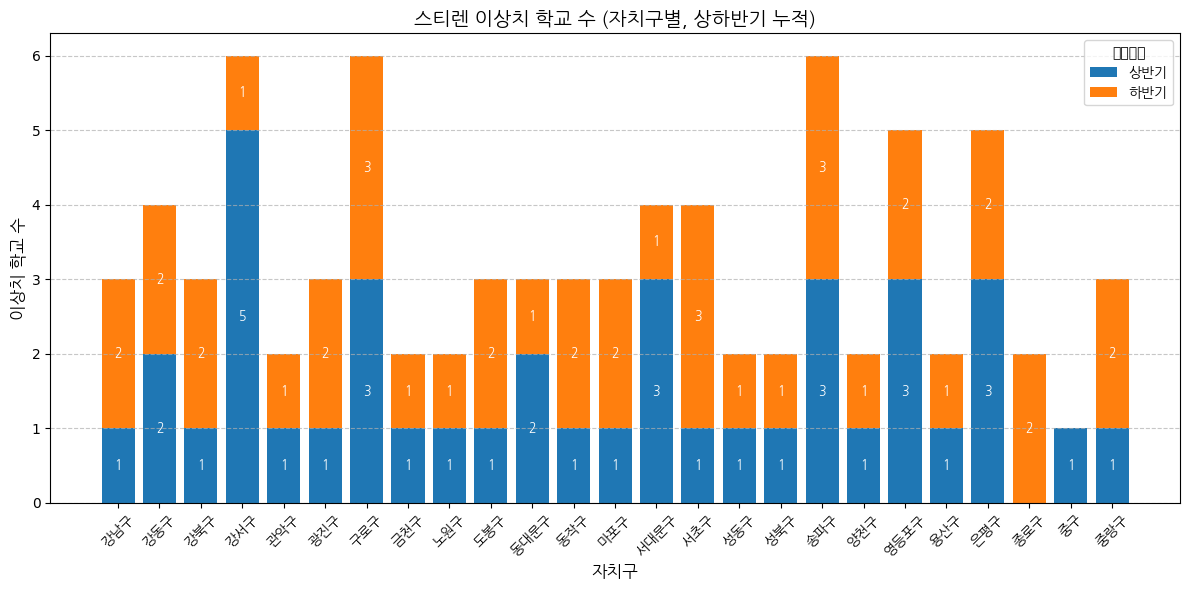

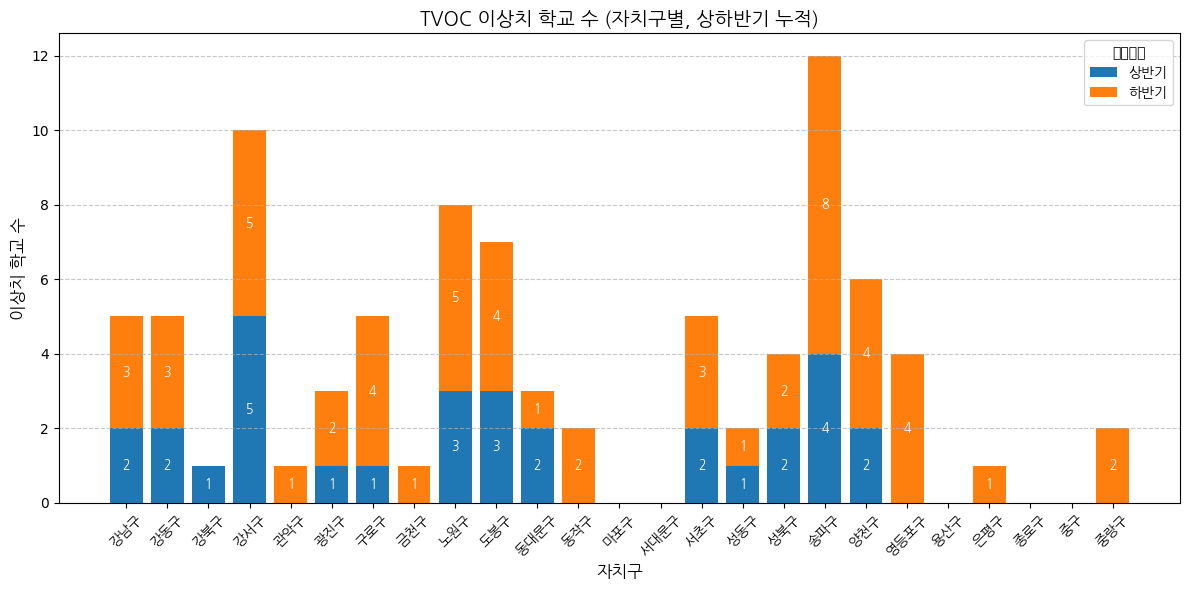

In [ ]:
for material in df_last["물질"].unique():
    subset = df_last[df_last["물질"] == material]

    # 자치구별, 상하반기별 이상치 수 계산
    grouped = subset.groupby(["자치구", "상하반기"])
    outlier_counts = grouped.apply(lambda g: (g["최종값"] > (g["최종값"].mean() + 2 * g["최종값"].std())).sum())

    if outlier_counts.empty:
        continue

    gu_names = sorted(set(idx[0] for idx in outlier_counts.index))
    semesters = sorted(set(idx[1] for idx in outlier_counts.index if idx[1] is not None))

    counts_per_sem = {sem: [] for sem in semesters}
    for gu in gu_names:
        for sem in semesters:
            counts_per_sem[sem].append(outlier_counts.get((gu, sem), 0))

    x = np.arange(len(gu_names))

    fig, ax = plt.subplots(figsize=(12, 6))

    bottom = np.zeros(len(gu_names))
    colors = ['#1f77b4', '#ff7f0e']  # 상반기, 하반기 색상 (필요시 변경)

    for i, sem in enumerate(semesters):
        counts = counts_per_sem[sem]
        ax.bar(x, counts, bottom=bottom, label=sem, color=colors[i])
        bottom += counts

    ax.set_title(f"{material} 이상치 학교 수 (자치구별, 상하반기 누적)", fontproperties=font_prop, fontsize=14)
    ax.set_xlabel("자치구", fontproperties=font_prop, fontsize=12)
    ax.set_ylabel("이상치 학교 수", fontproperties=font_prop, fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(gu_names, fontproperties=font_prop, rotation=45, fontsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend(title="상하반기", prop=font_prop)

    # 누적 막대 위에 텍스트 표시
    for idx in range(len(gu_names)):
        height = 0
        for sem in semesters:
            val = counts_per_sem[sem][idx]
            if val > 0:
                ax.text(idx, height + val / 2, str(val),
                        ha='center', va='center', fontproperties=font_prop, fontsize=9, color='white')
                height += val

    plt.tight_layout()
    plt.show()


In [ ]:
not_performed_counts = {}

for material, info in targets.items():
    # 측정값 컬럼명에서 접두사 추출 (first 컬럼 기준)
    first_col = info.get("first")
    if not first_col:
        continue
    prefix = first_col.split("_")[0]  # 예: 'HCHO_RSLT_NMVL' → 'HCHO'

    status_col = f"{prefix}_STB_YN"  # 예: 'HCHO_STB_YN'

    if status_col not in df.columns:
        continue

    df_sub = df[df[status_col] == "미실시"]

    counts = df_sub.groupby("SEM_STR")["SCHUL_NM"].nunique()

    not_performed_counts[material] = counts.to_dict()

# 보기 좋은 데이터프레임으로 변환
result_df = pd.DataFrame(not_performed_counts).fillna(0).astype(int)
print(result_df)


     폼알데하이드   벤젠  톨루엔  자일렌  스티렌  TVOC
상반기      62  126  118  127  128   116
하반기      13  162  158  159  161   159


In [ ]:
not_performed_counts = {}

for material, info in targets.items():
    first_col = info.get("first")
    if not first_col:
        continue
    prefix = first_col.split("_")[0]
    status_col = f"{prefix}_STB_YN"

    if status_col not in df.columns:
        continue

    # '미실시' 또는 '해당없음' 포함
    df_sub = df[df[status_col].isin(["해당없음"])]

    counts = df_sub.groupby("SEM_STR")["SCHUL_NM"].nunique()
    not_performed_counts[material] = counts.to_dict()

result_df = pd.DataFrame(not_performed_counts).fillna(0).astype(int)
print(result_df)


     폼알데하이드   벤젠  톨루엔  자일렌  스티렌  TVOC
상반기      94  616  597  608  615   599
하반기      18  446  441  443  447   444


# 환경변수 분석

### 평가 함수
**1. 신뢰도 평가 함수**
1차 측정값과 최종 측정값이 너무 다를 경우

편차율(%)	신뢰도 등급	점수
- 0% ~ 20% :	1.0
- 20% ~ 50%	:	0.7
- 50% ~ 80%	:	0.5
- 80% 초과 : 0.3 또는 제외

**2. 근접도 평가 함수**
기준치 넘지 않아도 기준치에 다다르면 위험함
- 기준치 : 100
- 측정값 : 99 라면 위험함!

**3.개별물질 위험도 점수 계산**

물질별 위험한 정도가 다름-> 기본 가중치를 다르게 둠

**최종점수**
= 기준 근접도 x 신뢰도 x 위험점수

In [ ]:
import pandas as pd
import numpy as np

# ---------------------
# 신뢰도 평가 함수
# ---------------------
def compute_reliability(first, final):
    # 0이거나 음수는 결측 처리로 간주
    if pd.isna(final) or first <= 0 or pd.isna(first):
        return 1.0
    diff_ratio = abs(first - final) / first
    if diff_ratio <= 0.2:
        return 1.0
    elif diff_ratio <= 0.5:
        return 0.7
    elif diff_ratio <= 0.8:
        return 0.5
    else:
        return 0.3

# ---------------------
# 기준치 근접도 평가 함수
# ---------------------
def score_proximity(value, limit):
    if pd.isna(value) or limit == 0:
        return 0
    ratio = value / limit
    if ratio >= 0.9:
        return 1.0
    elif ratio >= 0.6:
        return 0.7
    elif ratio >= 0.3:
        return 0.4
    else:
        return 0.1

# ---------------------
# 각 항목별 점수 계산 함수
# ---------------------
def get_material_score_with_check(row, material, info):
    status_col = material + "_STB_YN"
    first_col = info["first"]
    final_col = info["final"]
    limit = info["limit"]
    risk_score = info["risk_score"]

    #  '미실시', '미측정' 등 유사 상태를 모두 포함
    if row.get(status_col) in ["미실시", "미측정"]:
        return np.nan

    first = pd.to_numeric(row.get(first_col), errors='coerce')
    final = pd.to_numeric(row.get(final_col), errors='coerce')
    base_val = final if not pd.isna(final) else first

    if pd.isna(base_val):
        return np.nan

    reliability = compute_reliability(first, final)
    proximity = score_proximity(base_val, limit)
    return reliability * proximity * risk_score

# ---------------------
# 환경위험점수 계산
# ---------------------
def calculate_environment_risk_score(df, targets):
    # 벡터화가 어려워서 apply 사용 (성능은 보통)
    def calc_row_score(row):
        total_score = 0
        for name, info in targets.items():
            score = get_material_score_with_check(row, name, info)
            if not pd.isna(score):
                total_score += score
        return total_score

    return df.apply(calc_row_score, axis=1)

df["환경위험점수"] = calculate_environment_risk_score(df, targets)

# ---------------------
# TVOC 점수 계산
# ---------------------
def score_tvoc_proximity(value):
    if pd.isna(value): return 0
    ratio = value / 400 if 400 != 0 else 0
    if ratio >= 1.0: return 1.0
    elif ratio >= 0.75: return 0.7
    elif ratio >= 0.5: return 0.4
    else: return 0.1

def get_tvoc_score(row):
    first = pd.to_numeric(row.get("VOCS_RSLT_NMVL"), errors='coerce')
    final = pd.to_numeric(row.get("VOCS_RSLT_NMVL_3"), errors='coerce')
    base_val = final if not pd.isna(final) else first
    if pd.isna(base_val):
        return np.nan
    reliability = compute_reliability(first, final)
    proximity = score_tvoc_proximity(base_val)
    return 30 * proximity * reliability

df["TVOC_점수"] = df.apply(get_tvoc_score, axis=1)

# ---------------------
# 측정 권장 항목 추출
# ---------------------
def extract_missing_materials(row, targets):
    missing_materials = []
    for material, info in targets.items():
        status_col = material + "_STB_YN"
        status = row.get(status_col)

        # '해당없음', '미실시', '미측정' 포함 제외
        if status in ["해당없음", "미실시", "미측정"]:
            continue

        first = pd.to_numeric(row.get(info["first"]), errors='coerce')
        final = pd.to_numeric(row.get(info["final"]), errors='coerce')

        if pd.isna(first) and pd.isna(final):
            missing_materials.append(material)

    return ", ".join(missing_materials)

df["측정권장"] = df.apply(extract_missing_materials, axis=1, args=(targets,))

# ---------------------
# 측정 누락이 있는 학교 필터링
# ---------------------
df_recommend = df[df["측정권장"] != ""]


### 점수산출

- SEM: 상하반기 (1:상, 2:하)
- 환경위험점수 = 물질점수 = 기준근접도 x 근접도 x 위험
- TVOC 점수 = TVOC 점수=기준 근접도 (0.1 1.0)×신뢰도 (0.3 1.0)×최대30점

In [ ]:
def label_risk(score):
    if score >= 70:
        return "상"
    elif score >= 40:
        return "중"
    else:
        return "하"

df["위험등급"] = df["환경위험점수"].apply(label_risk)

top_45 = df.sort_values(by="환경위험점수", ascending=False).head(45)

cols = ["ADRCD_NM", "SEM_STR", "환경위험점수", "TVOC_점수", "위험등급", "SCHUL_NM"]

print(top_45[cols])


     ADRCD_NM SEM_STR  환경위험점수  TVOC_점수 위험등급        SCHUL_NM
1318     영등포구     상반기   188.0     30.0    상           대영중학교
3254      금천구     상반기   168.0     30.0    상           세일중학교
2281     영등포구     상반기   160.0     30.0    상        서울대방초등학교
551       동작구     하반기   160.0     30.0    상        서울신길초등학교
140       송파구     하반기   160.0     30.0    상        서울문정초등학교
2957      관악구     상반기   160.0     30.0    상        서울조원초등학교
3707     영등포구     하반기   160.0     30.0    상         여의도고등학교
2068      송파구     하반기   160.0     30.0    상        서울문정초등학교
2532      노원구     하반기   160.0     30.0    상        서울동일초등학교
1206      송파구     상반기   154.0     30.0    상           방이중학교
3066      강남구     상반기   149.0      3.0    상           구룡중학교
1137      강남구     하반기   133.0      3.0    상           구룡중학교
3161      송파구     하반기   119.5     21.0    상           잠신중학교
3058      성북구     상반기   116.3      1.5    상  서울대학교사범대학부설중학교
143       송파구     상반기   115.0      3.0    상        서울방이초등학교
1214      송파구     상반기   115.0      3.0  

In [ ]:
# 상위 5개 학교 추출
top_schools = df.sort_values(by="환경위험점수", ascending=False).head(5).copy()

# 유해물질별 점수 계산
for material, info in targets.items():
    top_schools[f"{material}_점수"] = top_schools.apply(
        lambda row: get_material_score_with_check(row, material, info), axis=1
    )

# TVOC 점수 계산
cols = ["SCHUL_NM", "환경위험점수", "TVOC_점수"] + [f"{m}_점수" for m in targets.keys()]
top_schools[cols]


,SCHUL_NM,환경위험점수,TVOC_점수,폼알데하이드_점수,벤젠_점수,톨루엔_점수,에틸벤젠_점수,자일렌_점수,스티렌_점수,TVOC_점수
1318,대영중학교,188.0,30.0,28.0,40.0,20.0,25.0,20.0,25.0,30.0
3254,세일중학교,168.0,30.0,8.0,40.0,20.0,25.0,20.0,25.0,30.0
2281,서울대방초등학교,160.0,30.0,NaN,40.0,20.0,25.0,20.0,25.0,30.0
551,서울신길초등학교,160.0,30.0,NaN,40.0,20.0,25.0,20.0,25.0,30.0
140,서울문정초등학교,160.0,30.0,NaN,40.0,20.0,25.0,20.0,25.0,30.0


In [ ]:
# 측정이 누락된 항목이 하나라도 있는 학교 보기
df_recommend = df[df["측정권장"] != ""]
df_recommend[["SCHUL_NM", "측정권장"]].head(20)

,SCHUL_NM,측정권장
0,서울교육대학교부설초등학교,"벤젠, 톨루엔, 에틸벤젠, 자일렌, 스티렌, TVOC"
1,서울교육대학교부설초등학교,폼알데하이드
2,서울대학교사범대학부설초등학교,폼알데하이드
3,서울대학교사범대학부설초등학교,폼알데하이드
4,서울개일초등학교,"폼알데하이드, 벤젠, 톨루엔, 에틸벤젠, 자일렌, 스티렌, TVOC"
5,서울개일초등학교,"폼알데하이드, 벤젠, 톨루엔, 에틸벤젠, 자일렌, 스티렌, TVOC"
6,서울구룡초등학교,폼알데하이드
7,서울구룡초등학교,폼알데하이드
8,서울논현초등학교,"벤젠, 톨루엔, 에틸벤젠, 자일렌, 스티렌, TVOC"
9,서울논현초등학교,"폼알데하이드, 벤젠, 톨루엔, 에틸벤젠, 자일렌, 스티렌, TVOC"


# 1. 위험등급 분포 및 지역별 비교


1-1. 위험등급별 빈도 분포 시각화 (전체 데이터)


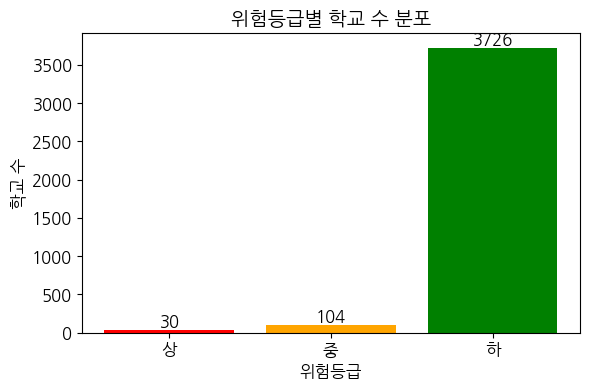

In [ ]:
risk_counts = df["위험등급"].value_counts().reindex(["상", "중", "하"]).fillna(0)

plt.figure(figsize=(6, 4))
bars = plt.bar(risk_counts.index, risk_counts.values, color=["red", "orange", "green"])

plt.title("위험등급별 학교 수 분포", fontproperties=font_prop, fontsize=14)
plt.xlabel("위험등급", fontproperties=font_prop, fontsize=12)
plt.ylabel("학교 수", fontproperties=font_prop, fontsize=12)
plt.xticks(fontproperties=font_prop, fontsize=12)
plt.yticks(fontproperties=font_prop, fontsize=12)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f"{int(height)}",
             ha='center', va='bottom', fontproperties=font_prop, fontsize=12)

plt.tight_layout()
plt.show()


1-2. 자치구별 평균 환경위험점수 비교

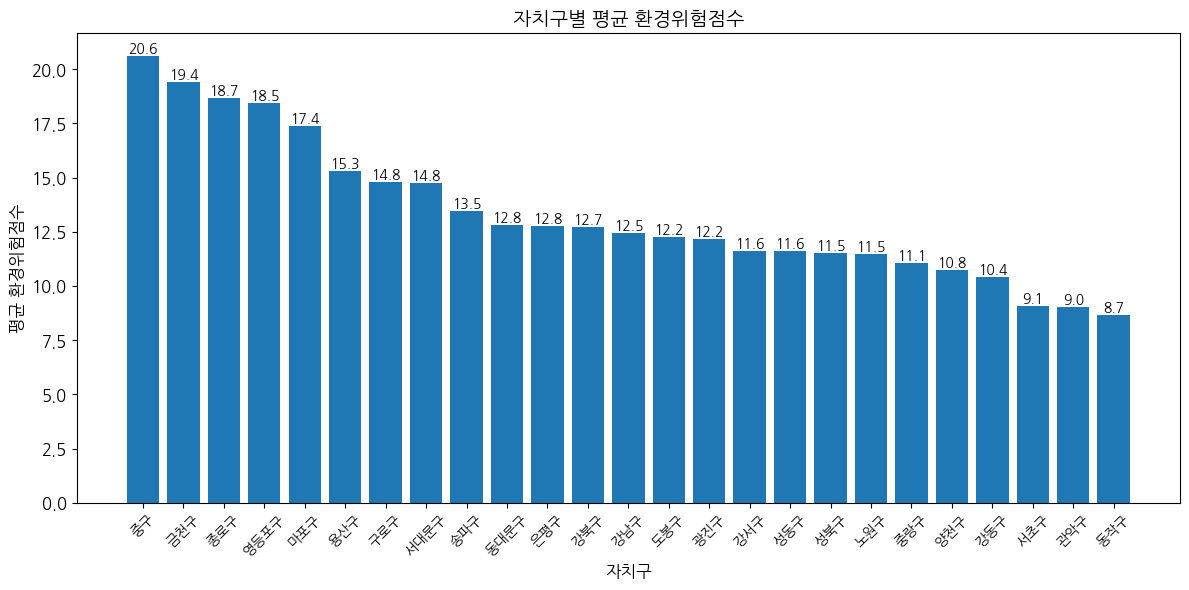

In [ ]:
# 자치구별 평균 위험점수 계산
avg_score_by_gu = df.groupby("ADRCD_NM")["환경위험점수"].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
bars = plt.bar(avg_score_by_gu.index, avg_score_by_gu.values)

plt.title("자치구별 평균 환경위험점수", fontproperties=font_prop, fontsize=14)
plt.xlabel("자치구", fontproperties=font_prop, fontsize=12)
plt.ylabel("평균 환경위험점수", fontproperties=font_prop, fontsize=12)
plt.xticks(rotation=45, fontproperties=font_prop, fontsize=10)
plt.yticks(fontproperties=font_prop, fontsize=12)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f"{height:.1f}",
             ha='center', va='bottom', fontproperties=font_prop, fontsize=10)

plt.tight_layout()
plt.show()


1-3. 자치구별 위험등급 분포 (Stacked bar chart)

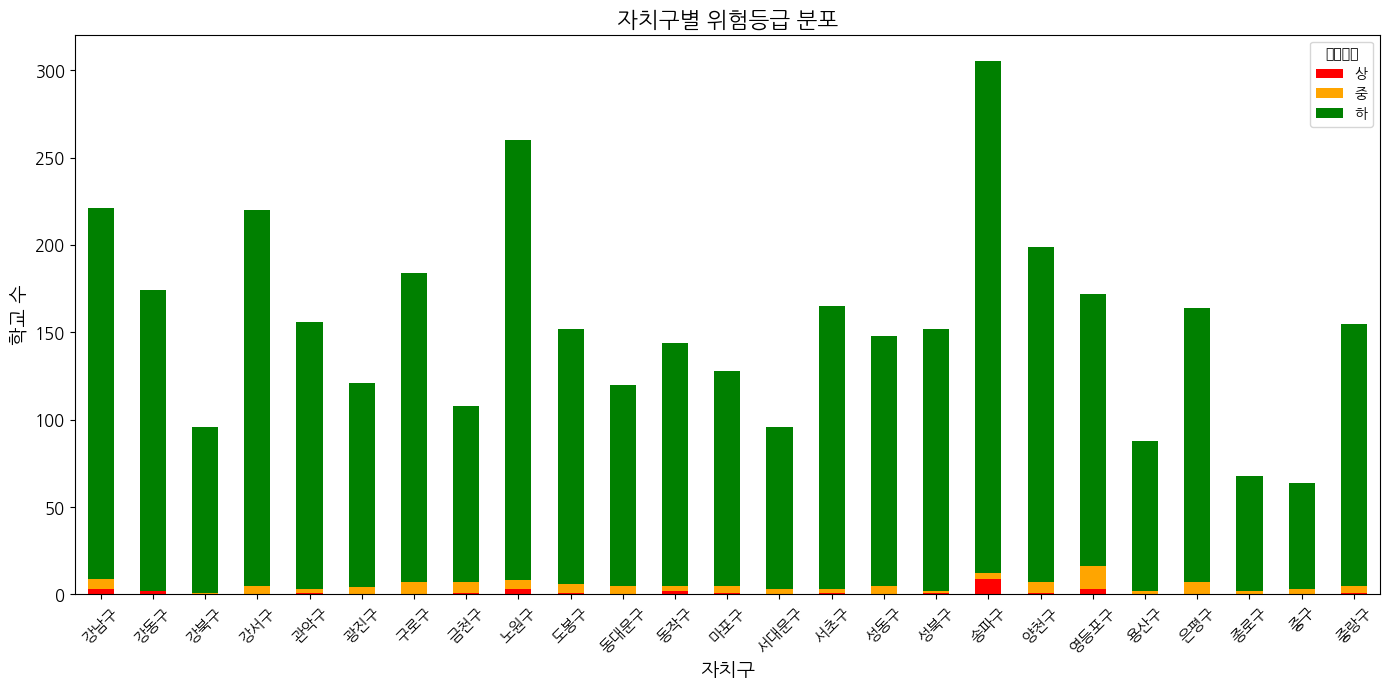

In [ ]:
# 위험등급별 자치구 그룹화 및 카운트
risk_dist_by_gu = df.groupby(["ADRCD_NM", "위험등급"])["SCHUL_NM"].count().unstack(fill_value=0)

risk_dist_by_gu = risk_dist_by_gu[["상", "중", "하"]]  # 위험등급 순서 맞춤

risk_dist_by_gu.plot(kind='bar', stacked=True, figsize=(14, 7),
                     color=["red", "orange", "green"])

plt.title("자치구별 위험등급 분포", fontproperties=font_prop, fontsize=16)
plt.xlabel("자치구", fontproperties=font_prop, fontsize=14)
plt.ylabel("학교 수", fontproperties=font_prop, fontsize=14)
plt.xticks(rotation=45, fontproperties=font_prop, fontsize=11)
plt.yticks(fontproperties=font_prop, fontsize=12)
plt.legend(title="위험등급", prop=font_prop)
plt.tight_layout()
plt.show()


# 2. 시간에 따른 변화 분석(원본 데이터가 아닌 위험도 산출로 인한 분석)

1. 각 학교·물질별 상반기/하반기 위험 점수 계산

In [ ]:
# (1) 물질별 위험 점수 생성 함수 예시 (필요하면 수정)
def calc_material_risk_score(row, material, info):
    # get_material_score_with_check 함수 참고
    status_col = material + "_STB_YN"
    first_col = info["first"]
    final_col = info["final"]
    limit = info["limit"]
    risk_score = info["risk_score"]

    if row.get(status_col) in ["미실시", "미측정"]:
        return np.nan

    first = pd.to_numeric(row.get(first_col), errors='coerce')
    final = pd.to_numeric(row.get(final_col), errors='coerce')
    base_val = final if not pd.isna(final) else first
    if pd.isna(base_val):
        return np.nan

    reliability = compute_reliability(first, final)
    proximity = score_proximity(base_val, limit)
    return reliability * proximity * risk_score

# (2) 모든 학교·물질에 대해 상반기/하반기별 점수 계산
records = []
for _, row in df.iterrows():
    sem = row.get("SEM_STR")
    school = row.get("SCHUL_NM")
    gu = row.get("ADRCD_NM")
    for material, info in targets.items():
        score = calc_material_risk_score(row, material, info)
        records.append({
            "학교명": school,
            "자치구": gu,
            "상하반기": sem,
            "물질": material,
            "위험점수": score
        })

df_risk = pd.DataFrame(records)

2. 상하반기별 위험 점수 차이 계산 (하반기 - 상반기)

In [ ]:
# (1) 상하반기별 학교·물질 평균 점수 집계
mean_scores = df_risk.groupby(["학교명", "물질", "상하반기"])["위험점수"].mean().unstack()

# (2) 상반기, 하반기 점수 차이 계산
mean_scores["점수차이"] = mean_scores.get("하반기", 0) - mean_scores.get("상반기", 0)

# (3) 위험 점수가 급격히 오른 학교 선별 (예: 점수차이 > 특정 임계치)
threshold = 10  # 필요시 조정
rising_schools = mean_scores[mean_scores["점수차이"] > threshold].copy()


3. 자치구별 위험 점수 변화 집계


In [ ]:
# df_risk에서 상하반기별 자치구·물질 평균 점수 집계
gu_scores = df_risk.groupby(["자치구", "물질", "상하반기"])["위험점수"].mean().unstack()

# 자치구별 점수 차이 계산
gu_scores["점수차이"] = gu_scores.get("하반기", 0) - gu_scores.get("상반기", 0)

# 급격히 증가한 자치구 추출
rising_gu = gu_scores[gu_scores["점수차이"] > threshold].copy()


In [ ]:
print("위험 점수가 급격히 오른 학교 예시:")
print(rising_schools.sort_values("점수차이", ascending=False).head(30))

print("\n위험 점수가 급격히 오른 자치구 예시:")
print(rising_gu.sort_values("점수차이", ascending=False).head(30))


위험 점수가 급격히 오른 학교 예시:
상하반기                     상반기    하반기   점수차이
학교명              물질                       
서울우장초등학교         TVOC   3.00  30.00  27.00
서울중현초등학교         TVOC   3.00  30.00  27.00
서울대학교사범대학부설여자중학교 TVOC   3.00  30.00  27.00
서울옥수초등학교         TVOC   3.00  30.00  27.00
불암고등학교           TVOC   3.00  21.00  18.00
서울개화초등학교         TVOC   3.00  21.00  18.00
서운중학교            TVOC   7.50  25.50  18.00
오금중학교            벤젠    22.00  40.00  18.00
원묵고등학교           TVOC  12.00  30.00  18.00
잠신중학교            TVOC   3.00  21.00  18.00
여의도고등학교          벤젠     4.00  22.00  18.00
서울연광초등학교         TVOC   3.00  21.00  18.00
서울난우초등학교         TVOC   3.00  21.00  18.00
서울수송초등학교         TVOC   3.00  21.00  18.00
서울신상도초등학교        벤젠     4.00  22.00  18.00
서울풍납초등학교         TVOC   3.00  21.00  18.00
을지중학교            TVOC   3.00  21.00  18.00
목동중학교            TVOC   6.30  21.00  14.70
방화중학교            TVOC   1.95  16.50  14.55
서울덕의초등학교         TVOC   3.00  16.50  13.50
여의도고등학교          TVOC  16.50  30.

In [ ]:
# 임계치 설정 (예: 10점)
threshold = 10

# 위험 점수 차이 계산 (하반기 - 상반기)
mean_scores["점수차이"] = mean_scores.get("하반기", 0) - mean_scores.get("상반기", 0)
gu_scores["점수차이"] = gu_scores.get("하반기", 0) - gu_scores.get("상반기", 0)

# 급격히 상승한 학교 및 자치구 (기존)
rising_schools = mean_scores[mean_scores["점수차이"] > threshold].copy()
rising_gu = gu_scores[gu_scores["점수차이"] > threshold].copy()

# 급격히 하락한 학교 및 자치구 (추가)
falling_schools = mean_scores[mean_scores["점수차이"] < -threshold].copy()
falling_gu = gu_scores[gu_scores["점수차이"] < -threshold].copy()

print("위험 점수가 급격히 떨어진 학교 예시:")
print(falling_schools.sort_values("점수차이").head(20))

print("\n위험 점수가 급격히 떨어진 자치구 예시:")
print(falling_gu.sort_values("점수차이").head(20))


위험 점수가 급격히 떨어진 학교 예시:
상하반기            상반기    하반기    점수차이
학교명      물질                       
서울갈산초등학교 벤젠    40.0  4.000 -36.000
방이중학교    벤젠    40.0  4.000 -36.000
서울천호초등학교 벤젠    40.0  4.000 -36.000
서울성서초등학교 벤젠    40.0  4.000 -36.000
세일중학교    벤젠    40.0  4.000 -36.000
송파중학교    벤젠    40.0  4.000 -36.000
봉은중학교    TVOC  30.0  3.000 -27.000
서울갈산초등학교 TVOC  30.0  3.000 -27.000
서울석계초등학교 TVOC  30.0  3.000 -27.000
서울선곡초등학교 TVOC  30.0  3.000 -27.000
서울연희초등학교 TVOC  30.0  3.000 -27.000
서울신화초등학교 TVOC  30.0  3.000 -27.000
서울성서초등학교 TVOC  30.0  3.000 -27.000
상경중학교    TVOC  30.0  3.000 -27.000
방이중학교    TVOC  30.0  3.000 -27.000
서울선곡초등학교 벤젠    28.0  4.000 -24.000
중화중학교    벤젠    28.0  4.000 -24.000
세일중학교    에틸벤젠  25.0  2.125 -22.875
서울성서초등학교 스티렌   25.0  2.500 -22.500
서울천호초등학교 스티렌   25.0  2.500 -22.500

위험 점수가 급격히 떨어진 자치구 예시:
Empty DataFrame
Columns: [상반기, 하반기, 점수차이]
Index: []


# 3. 상관관계 및 다중 위험 요인 분석

3-1. 여러 물질별 점수 간 상관관계 분석



**어떤 ‘위험점수’를 가지고 상관관계를 했나요?**
원본 측정값과 상태, 기준치, 위험가중치 등을 반영해 계산한 점수입니다.

즉,단순히 원측정값(raw 수치)을 쓴 게 아니라,

신뢰도(reliability), 기준치 대비 근접도(proximity), 물질별 위험 가중치(risk_score) 등이 복합 반영된 의미 있는 위험지표 점수를 사용했습니다.


---



**왜 이렇게 계산한 점수를 사용했나요?**
(1) 데이터 품질과 신뢰도 반영
동일한 수치라도 측정 신뢰도가 다르면 위험 수준 판단이 달라집니다.

compute_reliability 함수를 통해 1차와 최종 측정값 차이를 반영하여 신뢰도를 조정했습니다.

(2) 기준치 대비 상대적 위험 정도 반영
단순 수치보다 기준치 대비 어느 정도 근접하거나 초과했는지가 더 중요합니다.

score_proximity 함수가 이 부분을 수치화합니다.

(3) 물질별 위험도 차이를 반영
모든 물질이 위험도가 같은 게 아니기 때문에,

물질별 risk_score 가중치를 곱해 실제 위험도에 차등을 뒀습니다.


---

**요약**
| 원측정값(raw data) | → | 신뢰도 조정, 기준치 대비 근접도, 위험 가중치 반영 | → | 물질별 위험 점수(Composite Risk Score) | → | 상관관계 분석, 복합 위험 분석 |

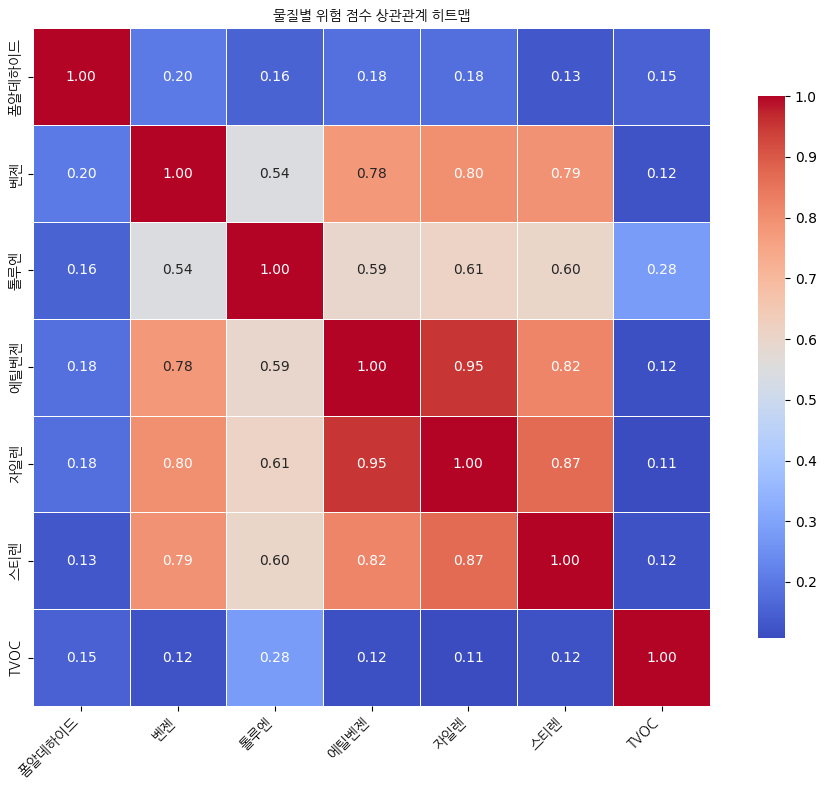

In [ ]:
# 1. 물질별 점수 컬럼 생성
for material, info in targets.items():
    col_name = f"{material}"
    df[col_name] = df.apply(lambda row: get_material_score_with_check(row, material, info), axis=1)

# 2. 물질별 점수 컬럼 리스트
score_cols = [f"{mat}" for mat in targets.keys()]

# 3. 상관계수 행렬 계산
corr_matrix = df[score_cols].corr()

# 4. 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True,
            cbar_kws={"shrink": 0.8}, linewidths=0.5)

plt.title("물질별 위험 점수 상관관계 히트맵", fontsize=16, fontproperties=font_prop)
plt.xticks(rotation=45, ha='right', fontproperties=font_prop)
plt.yticks(fontproperties=font_prop)
plt.tight_layout()
plt.show()


3-2. 복합 위험 지표 생성

In [ ]:
# 고위험 물질 판단 기준 (예: 점수 >= 0.7 이상)
threshold = 0.7

# 고위험 물질 개수 컬럼 생성
df["고위험_물질_개수"] = df[score_cols].apply(lambda row: (row >= threshold).sum(), axis=1)

# 고위험 복합 지표 (예: 고위험 물질 3개 이상 학교 필터링)
high_risk_schools = df[df["고위험_물질_개수"] >= 3]

print(f"고위험 물질 3개 이상인 학교 수: {high_risk_schools.shape[0]}")


고위험 물질 3개 이상인 학교 수: 1938


# 4. 예측 모델링

In [ ]:
df["환경위험점수"] = calculate_environment_risk_score(df, targets)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# 1. 필요한 컬럼 준비
feature_cols = ["건물연령", "ADRCD_NM", "학교급코드"]
target_col = "환경위험점수"

# 2. 결측치가 있는 행 제거 (설명변수 및 타겟 모두)
df_model = df[feature_cols + [target_col]].dropna()

# 3. 범주형 변수 인코딩
le_gu = LabelEncoder()
df_model["자치구_enc"] = le_gu.fit_transform(df_model["ADRCD_NM"])

le_grade = LabelEncoder()
df_model["학교급코드_enc"] = le_grade.fit_transform(df_model["학교급코드"])

# 4. 최종 feature, target 설정
X = df_model[["건물연령", "자치구_enc", "학교급코드_enc"]]

y = df_model[target_col]

# 5. 학습용, 평가용 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 6. 모델 학습 (랜덤포레스트 회귀)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 7. 평가
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.3f}")

# 8. 중요 변수 확인
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("변수 중요도:")
print(importances)


RMSE: 14.713
변수 중요도:
건물연령         0.500973
자치구_enc      0.344667
학교급코드_enc    0.154360
dtype: float64
